# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from GEModel import GEModelClass
from consav import linear_interp

In [2]:
model = GEModelClass('baseline')
print(model)

Modelclass: GEModelClass

Parameters:
 sigma = 2.0 [float64]
 beta = 0.96 [float64]
 r = 0.03 [float64]
 w = 1.0 [float64]
 rho = 0.97 [float64]
 sigma_e = 0.25 [float64]
 Ne = 11 [int64]
 a_max = 200.0 [float64]
 Na = 1000 [int64]
 simN = 1000000 [int64]
 max_iter_solve = 5000 [int64]
 max_iter_simulate = 5000 [int64]
 solve_tol = 1e-08 [float64]
 simulate_tol = 0.0001 [float64]
 a_grid = array(float64, 1d, C) with shape = (1000,)
 e_grid = array(float64, 1d, C) with shape = (11,)
 e_trans = array(float64, 2d, C) with shape = (11, 11)
 e_ergodic = array(float64, 1d, C) with shape = (11,)
 e_trans_cumsum = array(float64, 2d, C) with shape = (11, 11)
 e_ergodic_cumsum = array(float64, 1d, C) with shape = (11,)
memory, gb: 0.0

Solution:
 a = array(float64, 2d, C) with shape = (11, 1000)
 m = array(float64, 2d, C) with shape = (11, 1000)
 c = array(float64, 2d, C) with shape = (11, 1000)
 V = array(float64, 2d, C) with shape = (11, 1000)
 Va = array(float64, 2d, C) with shape = (11, 1000

**Productivity states:**

In [3]:
par = model.par
sol = model.sol
sim = model.sim

for e,pr_e in zip(par.e_grid,par.e_ergodic):
    print(f'Pr[e = {e:.4f}] = {pr_e:.4f}')
    
assert np.isclose(np.sum(par.e_grid*par.e_ergodic),1.0)

Pr[e = 0.4396] = 0.0010
Pr[e = 0.5150] = 0.0098
Pr[e = 0.6032] = 0.0439
Pr[e = 0.7065] = 0.1172
Pr[e = 0.8275] = 0.2051
Pr[e = 0.9693] = 0.2461
Pr[e = 1.1353] = 0.2051
Pr[e = 1.3298] = 0.1172
Pr[e = 1.5576] = 0.0439
Pr[e = 1.8244] = 0.0098
Pr[e = 2.1369] = 0.0010


# Solve

In [4]:
model.solve(do_print=True)

household problem solved in 4.8 secs [434 iterations]
[value function abs. max diff. is 0.00000001]


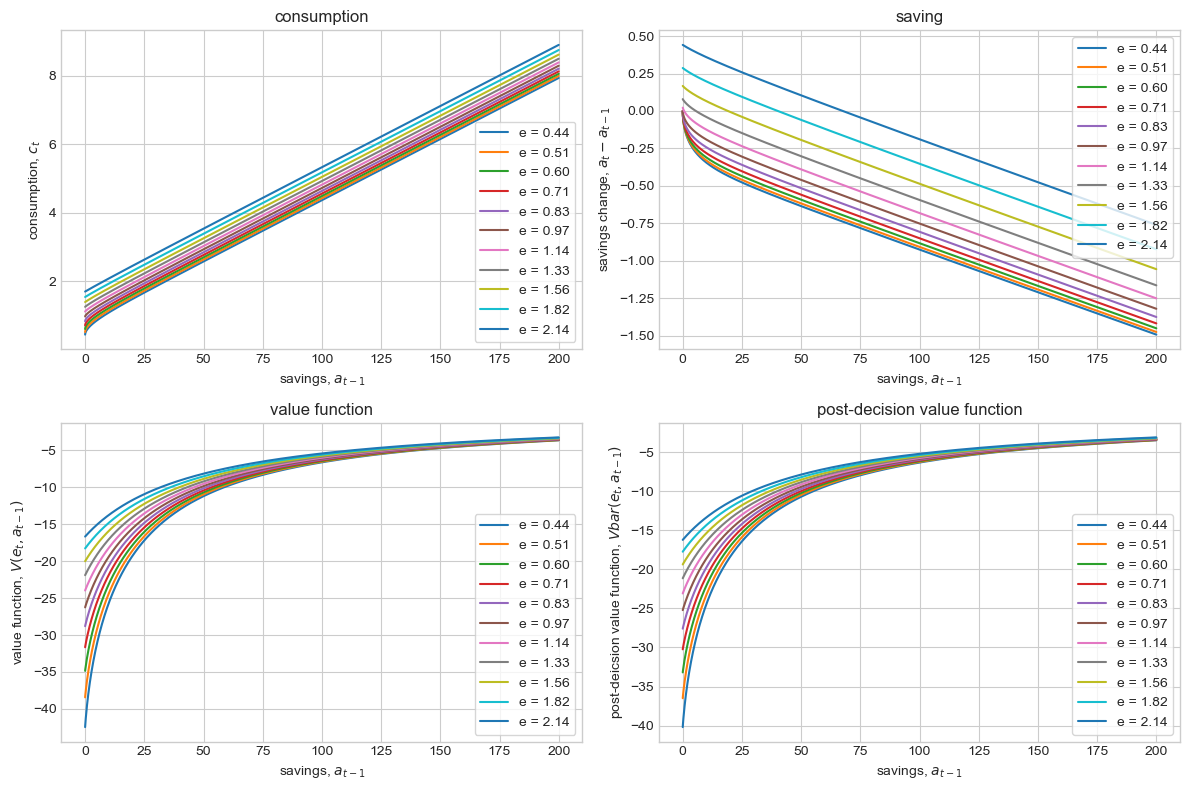

In [5]:
fig = plt.figure(figsize=(12,8),dpi=100)

# a. consumption
ax = fig.add_subplot(2,2,1)
ax.set_title('consumption')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.c[i_e,:],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(2,2,2)
ax.set_title('saving')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.a[i_e,:]-par.a_grid,label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

# c. value function
ax = fig.add_subplot(2,2,3)
ax.set_title('value function')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.V[i_e],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('value function, $V(e_t,a_{t-1})$')

# c. post-decision value function
ax = fig.add_subplot(2,2,4)
ax.set_title('post-decision value function')

for i_e,e in enumerate(par.e_grid):
    ax.plot(par.a_grid,sol.Vbar[i_e],label=f'e = {e:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('post-deicsion value function, $Vbar(e_t,a_{t-1})$')


fig.tight_layout()

# Test of matrix-form

**Define matrices:**

In [6]:
#Q
Q = np.zeros(par.Ne*par.Na)
from scipy.linalg import block_diag
#unpack
Ne=par.Ne
Na=par.Na

lis = []

#calculate
for e in range(Ne):
    q = np.zeros((Na,Na)) #create each Q_i
    for k in range(Na):
        opt = sol.a[e,k]
        if opt >= np.max(par.a_grid):
            q[k,Na-1] = 1 #If opt equals the end point

        elif opt <= np.min(par.a_grid):
            q[k,0] = 1 #If opt equals the start point

        else:   
            a_high = np.min(np.nonzero(opt<=par.a_grid)) #create points
            a_low = np.max(np.nonzero(opt>=par.a_grid))
            q[k,a_low] = (par.a_grid[a_low+1]-opt)/(par.a_grid[a_low+1]-par.a_grid[a_low])
            q[k,a_high] = (opt-par.a_grid[a_high-1])/(par.a_grid[a_high]-par.a_grid[a_high-1])
    lis.append(q)
    
Q = block_diag(*lis) #make block matrix from Q's

#Jeg har ændret q[k,a_low] fra (opt-par.a_grid[a_low])/(par.a_grid[a_low+1]-par.a_grid[a_low]) i lyx-noten til ovenstående.
#Jeg har måske et problem, hvis sol.a[e,k] ligger uden for grid'et.

#Pi
Pit = np.kron(par.e_trans, np.identity(Na))

**Calculate $\Omega$**

In [7]:
Omega = Q@Pit

**Test:**

In [8]:
v_vec = np.reshape(sol.V,(par.Ne*par.Na,1))
c_vec = np.reshape(sol.c,(par.Ne*par.Na,1))
vbar_vec = np.reshape(sol.Vbar,(par.Ne*par.Na,1))
u_vec = c_vec**(1-par.sigma)/(1-par.sigma)
v_vec_next = u_vec + par.beta*Omega@v_vec
max_abs_diff = np.max(np.abs(v_vec-v_vec_next))
print(f'We should max_abs_diff = 0.0')
print(f'We have max_abs_diff   = {max_abs_diff:.8f}')

We should max_abs_diff = 0.0
We have max_abs_diff   = 0.00000001


# Simulate

In [9]:
model.simulate(do_print=True)

household problem simulated in 24.7 secs [219 iterations]


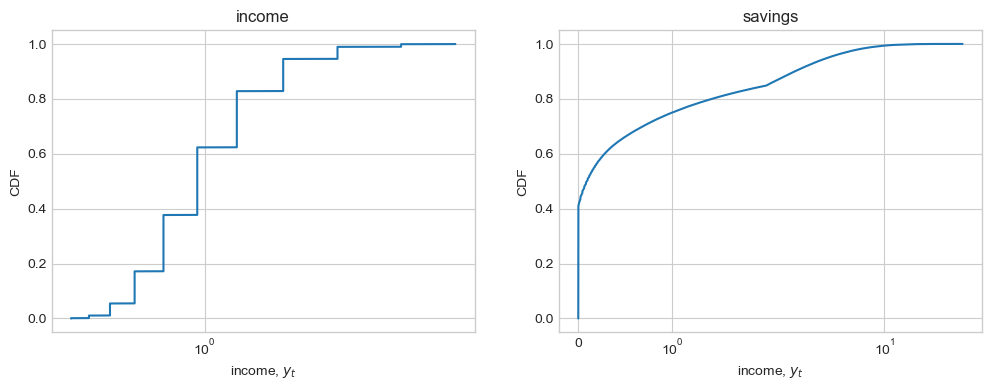

In [10]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('income')
ax.plot(np.sort(sim.y),np.arange(par.simN)/par.simN)
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
ax.plot(np.sort(sim.a),np.arange(par.simN)/par.simN)
ax.set_xlabel('income, $y_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

In [11]:
print(f'mean y: {np.mean(sim.y):.2f}')
print(f'std. y: {np.std(sim.y):.2f}')

mean y: 1.00
std. y: 0.25


In [12]:
print(f'mean a: {np.mean(sim.a):.2f}')
print(f'std. a: {np.std(sim.a):.2f}')

mean a: 0.92
std. a: 1.83
